In [1]:
from collections import defaultdict
from typing import Self
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 04: Seleção de modelo e hiperparametros

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de treino e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [2]:
SEED = 0
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED
)

In [3]:
# Regressão Linear com penalização L2 (Ridge Regression)
class RidgeRegression:
    def __init__(self, c: float) -> None:
        self.c = c
        self.theta: np.ndarray = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        n, m = X.shape
        self.X = np.c_[np.ones((n, 1)), X]
        I = np.eye(m + 1)
        I[0, 0] = 0
        # Use a fórmula analítica para estimar os pesos do modelo de regressão
        self.theta = np.linalg.pinv(self.X.T @ self.X + self.c * I) @ self.X.T @ y
        # self.theta = np.linalg.solve(self.X.T @ self.X + self.c * I, self.X.T @ y)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        n = X.shape[0]
        X = np.c_[np.ones((n, 1)), X]
        return X @ self.theta

# Calcula o erro quadrático médio
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean((y_true - y_pred) ** 2)

In [4]:
c_values = np.logspace(-5, 5, num=1000)
best_mse = float('inf')
best_c = None

# Para cada valor de c, treina o modelo usando a penalização L2 e calcula o erro quadrático médio
for c in c_values:
    theta = RidgeRegression(c)
    theta.fit(X_train, y_train)
    y_pred = theta.predict(X_val)
    error = mse(y_val, y_pred)
    # Atualiza o melhor valor de c
    if error < best_mse:
        best_mse = error
        best_c = c

print(f'Melhor coeficiente de regularização: {best_c}')

Melhor coeficiente de regularização: 49.73895958790068


In [5]:
# Plote os MSE no conjunto de trieno e validação em função de c.
train_errors = []
val_errors = []

for c in c_values:
    theta = RidgeRegression(c)
    theta.fit(X_train, y_train)
    y_pred_train = theta.predict(X_train)
    y_pred_val = theta.predict(X_val)

    train_errors.append(mse(y_train, y_pred_train))
    val_errors.append(mse(y_val, y_pred_val))

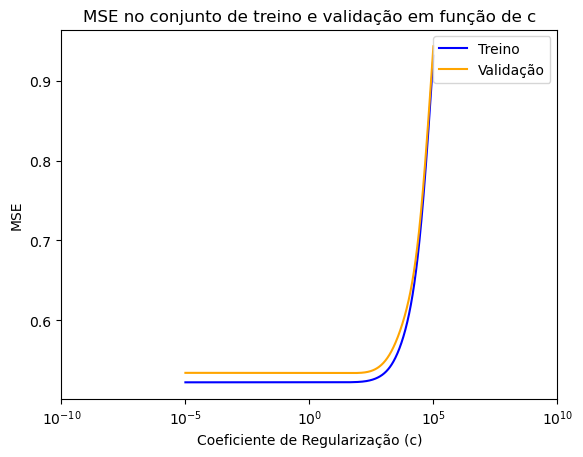

In [6]:
plt.plot(c_values, train_errors, label='Treino', color='blue')
plt.plot(c_values, val_errors, label='Validação', color='orange')
plt.xscale('log')
plt.xlabel('Coeficiente de Regularização (c)')
plt.xticks([1e-10, 1e-5, 1, 1e5, 1e10])
plt.ylabel('MSE')
plt.legend()
plt.title('MSE no conjunto de treino e validação em função de c')
plt.show()

Ao avaliar a performance do modelo ótimo no conjunto de teste, temos que:

In [7]:
class_ = RidgeRegression(best_c)
class_.fit(X_train, y_train)

y_test_pred = class_.predict(X_test)
test_error = mse(y_test, y_test_pred)

print(f'Mse com melhor c ({best_c}): {test_error}')

Mse com melhor c (49.73895958790068): 0.5387553011203188


Podemos ver que o melhor coeficiente de regularização é $\approx 49.16$ e o erro no conjunto de teste com esse coeficiente é $\approx 0.538$. Pelo gráfico, quando $c$ continua a aumentar após esse ponto ótimo, o erro no conjunto de treino começa a aumentar. Isso é indicativo de que para valores muito altos de $c$, o modelo pode começar a sofrer de overfitting, o que significa que está começando a ser penalizado em excesso pela regularização, perdendo a capacidade de se ajustar bem até mesmo aos dados de treino. 

## Questão 2

**2.** Implemente 5-fold *nested cross-validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido (use 5-fold cross validation regular para isso)?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

Obs. 2: para mais informações sobre o $K$-fold *nested cross-validation*, recomendamos esses materiais:
- [Algoritmo e breve explicação](https://weina.me/nested-cross-validation): a autora apresenta uma boa explicação do assunto acompanhada de uma descrição do algoritmo;
- [Ilustrações e explicação acompanhada de código](https://ploomber.io/blog/nested-cv/): ajuda a visualizar melhor o que é *nested cross-validation*; vale lembrar que seu código, diferente do dos exemplos desse link, não deve utilizar scikit-learn para implementar a *cross-validation*. 

In [8]:
class KFold:
    def __init__(
        self, n_splits: int, seed: int | None = None
    ) -> None:
        # Número de divisões (folds)
        self.n_splits = n_splits
        self.seed = seed

    def split(self, X: np.ndarray, y: np.ndarray):
        n = X.shape[0]
        np.random.seed(self.seed)
        # Cria uma permutação aleatória dos índices
        indices = np.random.permutation(n)
        # Para cada divisão na validação cruzada
        for i in range(self.n_splits):
            # Calcula o índice de início e fim da divisão atual
            start = i * n // self.n_splits
            end = (i + 1) * n // self.n_splits

            # Cria os índices de treino e validação
            train = np.concatenate([indices[:start], indices[end:]])
            validation = indices[start:end]

            # Retorna os conjuntos de treino e validação
            yield X[train], X[validation], y[train], y[validation]

In [9]:
class CrossValidation:
    def __init__(
        self, class_: type, parameters: list[float],
        n_splits: int, seed: int | None = None, log_results: bool = False
    ) -> None:
        self.class_ = class_
        self.parameters = parameters
        self.n_splits = n_splits # Número de folds
        self.seed = seed
        self.log_results = log_results
        # Cada valor terá um array com os erros de cada fold
        self.errors: defaultdict[float, np.ndarray] = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        # Inicializa o dicionário de erros com arrays de zeros
        default_constructor = lambda: np.zeros(self.n_splits)
        self.errors = defaultdict(default_constructor)
        # Cria um objeto KFold para a validação cruzada
        kfold = KFold(self.n_splits, self.seed)

        # Para cada fold, treina o modelo com cada parâmetro e calcula o erro
        for i, (X_train, X_val, y_train, y_val) in enumerate(kfold.split(X, y)):
            for value in self.parameters:
                model = self.class_(value).fit(X_train, y_train)
                y_pred = model.predict(X_val) # Faz a predição
                error = mse(y_val, y_pred) # Calcula o erro
                self.errors[value][i] += error # Adiciona o erro ao array do parâmetro

                if self.log_results:
                    print(f'Parâmetro: {value} - Fold {i + 1} - MSE: {error:.5f}')
        return self

    @property
    def best_parameter(self):
        # Retorna o parâmetro com o menor erro médio
        return min(self.errors, key=lambda k: self.errors[k].mean())

    @property
    def best_model(self):
        # Retorna o modelo com o melhor parâmetro
        return self.class_(self.best_parameter)

In [10]:
# Concatena os conjuntos de treino e validação
X_train = np.concatenate([X_train, X_val]) 
y_train = np.concatenate([y_train, y_val])

In [11]:
n_splits = 5
kfold = KFold(n_splits, SEED)

# Configuração dos parâmetros para cada modelo
config = {
    KNeighborsRegressor: list(range(1, 6)),
    RidgeRegression: [0, 1, 10, 100]
}

# Inicializa um dicionário para armazenar os erros de cada modelo
errors = {
    class_: np.zeros(n_splits) for class_ in config.keys()
}

print('Iniciando a validação cruzada...')
# Para cada classe de modelo e seus parâmetros
for class_, params in config.items():
    # Para cada divisão da validação cruzada
    for i, (X_train_, X_val, y_train_, y_val) in enumerate(kfold.split(X_train, y_train)):
        # Cria um objeto CrossValidation para o modelo atual
        cv = CrossValidation(class_, params, n_splits, SEED, log_results=True)
        cv.fit(X_train_, y_train_)
        # Obtém o melhor modelo e ajusta aos dados de treino
        best_model = cv.best_model.fit(X_train_, y_train_)
        # Faz a previsão para os dados de validação
        y_pred = best_model.predict(X_val)
         # Calcula o erro quadrático médio da previsão
        error = mse(y_val, y_pred)
         # Armazena o erro no dicionário de erros
        errors[class_][i] = error
        print(f'Modelo: {class_.__name__} - Fold: {i + 1} - MSE: {error:.5f}\n')

print("\n")

# Obtém a classe de modelo que teve o menor erro médio
best_class = min(errors, key=lambda k: errors[k].mean())
cv = CrossValidation(
    best_class, config[best_class], n_splits, SEED, log_results=True
).fit(X_train, y_train)
# Obtém o melhor modelo e ajusta aos dados de treino
best_model = cv.best_model.fit(X_train, y_train)
# Faz a previsão para os dados de teste
y_pred = best_model.predict(X_test)
# Calcula o erro quadrático médio da previsão
error = mse(y_test, y_pred)

print(f'\n\nMelhor modelo: {best_class.__name__}')
print(f'Melhor valor do parâmetro: {cv.best_parameter}')
print(f'MSE no conjunto de teste: {error:.5f}')

Iniciando a validação cruzada...
Parâmetro: 1 - Fold 1 - MSE: 1.75532
Parâmetro: 2 - Fold 1 - MSE: 1.41781
Parâmetro: 3 - Fold 1 - MSE: 1.29262
Parâmetro: 4 - Fold 1 - MSE: 1.23878
Parâmetro: 5 - Fold 1 - MSE: 1.19658
Parâmetro: 1 - Fold 2 - MSE: 1.65331
Parâmetro: 2 - Fold 2 - MSE: 1.37090
Parâmetro: 3 - Fold 2 - MSE: 1.26333
Parâmetro: 4 - Fold 2 - MSE: 1.20202
Parâmetro: 5 - Fold 2 - MSE: 1.18925
Parâmetro: 1 - Fold 3 - MSE: 1.64711
Parâmetro: 2 - Fold 3 - MSE: 1.34047
Parâmetro: 3 - Fold 3 - MSE: 1.24270
Parâmetro: 4 - Fold 3 - MSE: 1.19901
Parâmetro: 5 - Fold 3 - MSE: 1.18478
Parâmetro: 1 - Fold 4 - MSE: 1.72897
Parâmetro: 2 - Fold 4 - MSE: 1.37842


Parâmetro: 3 - Fold 4 - MSE: 1.27584
Parâmetro: 4 - Fold 4 - MSE: 1.24874
Parâmetro: 5 - Fold 4 - MSE: 1.24406
Parâmetro: 1 - Fold 5 - MSE: 1.66751
Parâmetro: 2 - Fold 5 - MSE: 1.31643
Parâmetro: 3 - Fold 5 - MSE: 1.19303
Parâmetro: 4 - Fold 5 - MSE: 1.15675
Parâmetro: 5 - Fold 5 - MSE: 1.14222
Modelo: KNeighborsRegressor - Fold: 1 - MSE: 1.17717

Parâmetro: 1 - Fold 1 - MSE: 1.78848
Parâmetro: 2 - Fold 1 - MSE: 1.38571
Parâmetro: 3 - Fold 1 - MSE: 1.27794
Parâmetro: 4 - Fold 1 - MSE: 1.24126
Parâmetro: 5 - Fold 1 - MSE: 1.20836
Parâmetro: 1 - Fold 2 - MSE: 1.68897
Parâmetro: 2 - Fold 2 - MSE: 1.40651
Parâmetro: 3 - Fold 2 - MSE: 1.30841
Parâmetro: 4 - Fold 2 - MSE: 1.25722
Parâmetro: 5 - Fold 2 - MSE: 1.23531
Parâmetro: 1 - Fold 3 - MSE: 1.70898
Parâmetro: 2 - Fold 3 - MSE: 1.35699
Parâmetro: 3 - Fold 3 - MSE: 1.24524
Parâmetro: 4 - Fold 3 - MSE: 1.17956
Parâmetro: 5 - Fold 3 - MSE: 1.15081
Parâmetro: 1 - Fold 4 - MSE: 1.71908
Parâmetro: 2 - Fold 4 - MSE: 1.37988
Parâmetro: 3 - Fold 4

Neste código comparamos o KNN (K-Nearest Neighbors) e a Regressão Linear com regularização L2, variando os parâmetros $k$ e $c$ respectivamente, e selecionamos os melhores hiperparâmetros para cada modelo com base no erro quadrático médio do conjunto de validação.

A partir dos resultados da validação cruzada aninhada, foi possível identificar que a regressão com regularização L2 teve um melhor desempenho em média, com um valor de $c=100$ como o melhor hiperparâmetro. O MSE obtido no conjunto de teste para esse modelo foi de $\approx 0.531$.

A seleção do modelo Ridge Regression sobre o k-NN sugere que a regularização $L2$ foi benéfica para lidar com a complexidade do modelo e prevenir o overfitting, levando a uma melhor generalização nos dados de teste.

# Exercício de "papel e caneta"

**1.** Nas nota de aula, derivamos o "dilema viés-variância" calculando o MSE esperado entre a função alvo de aprendizado $f$ e a predição do nosso modelo $h_{\mathcal{D}}$:

$$
\mathbb{E}_{x, \mathcal{D}} 
    \left[ 
        \left( 
        h_{\mathcal{D}}(x) - f\left(x\right) 
        \right)^2
    \right] =
\mathbb{E}_{x}[\underbrace{\textrm{Var}_{\mathcal{D}}[
        h_{\mathcal{D}}(x)]}_{\text{ Variância} }] + \mathbb{E}_{x} [ (\underbrace{\mathbb{E}_{\mathcal{D}}[
        h_{\mathcal{D}}(x) - f\left(x\right)]  }_{\text{Viés}})^2] 
    ].
$$

Com isso em mente, adapte nossa derivação para o caso em que as respostas de teste $f(x)$ são corrompidas por um ruído aditivo aleatório $\epsilon$ com média zero, i.e., observamos $f^\prime(x) = f(x) + \epsilon$. Mais concretamente, trabalhe a seguinte esperança para derivar uma decomposição similar à da nota de aula:
$$
\mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        \left( 
        h_{\mathcal{D}}(x) - f^\prime\left(x\right)
        \right)^2
    \right].
$$

Compare a diferença entre a decomposição que você obteve e a da nota de aula.

Dica: sua decomposição deve se diferenciar da acima em apenas um termo aditivo, que envolve uma esperança sobre $x$ e $y$.


### Resposta:

Pelas notas de aula, vimos que:
$$
\begin{aligned}
\mathbb{E}_{x, \mathcal{D}}\left[\left(h_{\mathcal{D}}(x)-f'(x) \right)^2\right] & =\mathbb{E}_{x, \mathcal{D}}\left[h_{\mathcal{D}}(x)^2+f'(x) ^2-2 h_{\mathcal{D}}(x) f'(x) \right] \\
& =\mathbb{E}_x\left[\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)^2\right]\right]+\mathbb{E}_x\left[f'(x) ^2-2 \mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)\right] f'(x) \right]
\end{aligned}
$$

Ao somar $\mathbb{E}_{x, \mathcal{D}}\left[h_{\mathcal{D}}(x)\right]^2-\mathbb{E}_{x, \mathcal{D}}\left[h_{\mathcal{D}}(x)\right]^2$ à última linha para obter:

$$
\begin{aligned}
\mathbb{E}_{x, \mathcal{D}}\left[\left(h_{\mathcal{D}}(x)-f'(x) \right)^2\right] & = \underbrace{\mathbb{E}_x\left[\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)^2\right] -\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)\right]^2\right]}_{(1)}+\underbrace{\mathbb{E}_{x}\left[\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)\right]^2+ f'(x)^2 - 2 \mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] f'(x) \right]}_{\text{(2)}} \\
\end{aligned}
$$

Sabendo que a fórmula da variância é $Var(X) = \mathbb{E}[X^2] - \mathbb{E}[X]^2$, temos que (1) é:

$$\mathbb{E}_x\left[\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)^2\right] -\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)\right]^2\right] = \mathbb{E}_x\left[ Var_{\mathcal{D}}[h_{\mathcal{D}}(x)] \right]$$

Agora vamos expandir o termo $(2)$ que depende de $f'(x)$: 

$$\mathbb{E}_{x}\left[\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)\right]^2+ f'(x)^2 - 2 \mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] f'(x) \right] = \mathbb{E}_{x}\left[\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)\right]^2\right] + \underbrace{\mathbb{E}_{x}\left[f'(x)^2 \right]}_{(3)} - 2  \underbrace{\mathbb{E}_{x}  \left[\mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] f'(x)\right]}_{(4)}$$

Desenvolvendo $(3)$:

$$\mathbb{E}_{x}\left[f'(x)^2 \right] = \mathbb{E}_{x}\left[(f(x) + \epsilon)^2 \right] = \mathbb{E}_{x}\left[f(x)^2 + 2 f(x) \epsilon + \epsilon^2 \right]$$

$$ = \mathbb{E}_{x}\left[f(x)^2 \right] + 2\epsilon \underbrace{\mathbb{E}_{x}\left[f(x) \right]}_{0} + \mathbb{E}_{x}\left[\epsilon^2 \right]= \mathbb{E}_{x}\left[f(x)^2 \right] + \underbrace{\mathbb{E}_{x}\left[\epsilon^2 \right]}_{\sigma^2}$$

Novamente pela fórmula de variância, temos que:
$$\mathbb{E}_{x} Var(\epsilon) = \mathbb{E}_{x} \left[ \mathbb{E}_{\epsilon} \left[ \epsilon^2 \right] - \mathbb{E}_{\epsilon} \left[ \epsilon \right]^2 \right] = \mathbb{E}_{x} \left[ \sigma^2 - 0 \right] = \sigma^2$$

Então, temos que $\mathbb{E}_{x}\left[f'(x)^2 \right] = \mathbb{E}_{x}\left[f(x)^2 \right] + \mathbb{E}_{x} Var(\epsilon)$.

Por fim, desenvolvendo $(4)$:

$$
\begin{aligned}
\mathbb{E}_{x}  \left[\mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] f'(x)\right] & = \mathbb{E}_{x}  \left[\mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] (f(x) + \epsilon)\right] \\
& = \mathbb{E}_{x}  \left[\mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] f(x)\right] + \mathbb{E}_{x}  \left[\mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] \epsilon\right] \\
& = \mathbb{E}_{x}  \left[\mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] f(x)\right] \\
\end{aligned}
$$

Pois, $\mathbb{E}{x} \left[\mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] \epsilon\right] = \mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] \underbrace{\mathbb{E}{x}[\epsilon]}_{0} = 0$


Substituindo $(3)$ e $(4)$ em $(2)$, temos que:

$$
\begin{aligned}
\mathbb{E}_{x}\left[\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)\right]^2+ f'(x)^2 - 2 \mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] f'(x) \right] & = \mathbb{E}_{x}\left[\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)\right]^2\right] + \mathbb{E}_{x}\left[f(x)^2 \right] + \mathbb{E}_{x} Var(\epsilon) - 2 \mathbb{E}_{x}  \left[\mathbb{E}_\mathcal{D}\left[ h_{\mathcal{D}}(x)\right] f(x)\right] \\
& = \mathbb{E}_x\left[\left(\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)-f(x)\right]\right)^2\right] + \mathbb{E}_{x} Var(\epsilon)
\end{aligned}
$$

E portanto, 
$$
\begin{aligned}
\mathbb{E}_{x, \mathcal{D}}\left[\left(h_{\mathcal{D}}(x)-f'(x) \right)^2\right] & = (1) + (2)\\
& = \underbrace{\mathbb{E}_x\left[ Var_{\mathcal{D}}[h_{\mathcal{D}}(x)] \right]}_{\text{Variância}} + \underbrace{\mathbb{E}_x\left[\left(\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)-f(x)\right]\right)^2\right]}_{Viés} + \underbrace{\mathbb{E}_{x} Var(\epsilon)}_{\text{Ruído}}
\end{aligned}
$$

Diferentemente da decomposição original, temos um termo adicional que representa o ruído presente nos dados, representado por $\mathbb{E}_{x} Var(\epsilon)$. Na decomposição original, ao usar apenas $f(x)$, obtínhamos:

$$\mathbb{E}_{x, \mathcal{D}}\left[\left(h_{\mathcal{D}}(x)-f(x)\right)^2\right]=\mathbb{E}_x[\underbrace{\operatorname{Var}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)\right]}_{\text {Variância }}]+\mathbb{E}_x[(\underbrace{\mathbb{E}_{\mathcal{D}}\left[h_{\mathcal{D}}(x)-f(x)\right]}_{\text {Viés }})^2]$$